Мы работали на Google Colab. Чтобы каждый раз вручную не загружать файлы в рабочее пространство, мы загразили файлы на диск, поэтому нужно его подключить.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
test = pd.read_excel('/content/drive/MyDrive/Test_unlabled.xlsx')
df = pd.read_excel('/content/drive/MyDrive/Train_labled.xlsx')

# Проанализируем данные

Диаграмма количества NaN

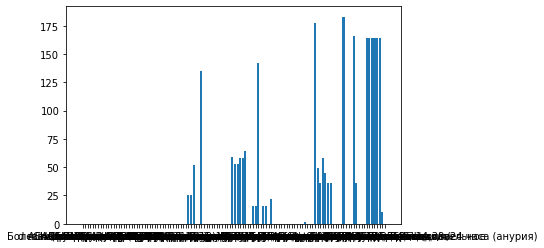

In [4]:
import matplotlib.pyplot as plt
plt.bar(df.isna().sum().index, df.isna().sum().values)
plt.show()

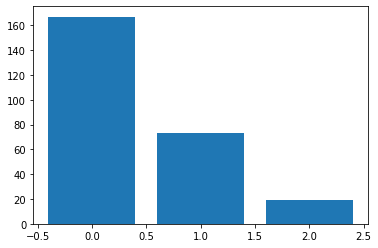

In [5]:
plt.bar(df['Текущий прогноз'].unique(), df['Текущий прогноз'].value_counts())
plt.show()

([<matplotlib.patches.Wedge at 0x7f16978096d0>,
 [Text(-0.48327404014581876, 0.9881529244611573, ''),
  Text(0.24477321382259096, -1.072420660839281, ''),
  Text(1.0709165255480224, -0.2512723528527406, '')])

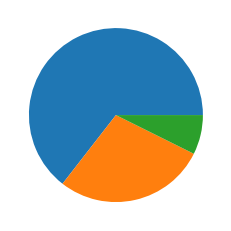

In [6]:
plt.pie(df['Текущий прогноз'].value_counts())

## Посчитаем корреляцию столбцов с таргетом

In [7]:
def correlate_cols_with_target(df, target):
  """Функция, возвращающая корреляцию каждого столбца из df со столбцом target"""
  corr = df.corr()[target]
  corr.sort_values()
  corr_df = pd.DataFrame(corr.sort_values())
  return corr_df

In [8]:
correlate_cols_with_target(df, 'Текущий прогноз').head(10)

,Текущий прогноз
стадия ХПН,-0.495264
Лечение рецидива,-0.475688
Ишемия да-нет,-0.427281
гемостатическая губка,-0.410592
Longitudinal,-0.400485
ХПН,-0.367882
Доступ первой резекции.1,-0.355598
Доступ первой резекции,-0.355598
кисты,-0.347374
Стадия,-0.337570


In [9]:
correlate_cols_with_target(df, 'Текущий прогноз').tail(10)

,Текущий прогноз
Швы через толщу паренхимы,0.376047
Сохранение резецированной почки длительное,0.476448
Время операции,0.580031
эффект лечения рецидива,0.628429
Рецидив,0.746358
Текущий прогноз,1.000000
рN,NaN
M,NaN
K+ max,NaN
эффект,NaN


## Обработка данных и устранение ошибок в датасете

* рN удаляем, т.к значения слишком одинаковые(243 нуля и 16 nan)
* M - удаляем, то же самое что pN
* K+ max - удаляем, т.к много нанов
* эффект - удаляем, т.к значения везде одинаковые

In [10]:
df = df.drop(['рN', 'M','K+ max', 'эффект'], axis = 1) #удаляем столбцы, у которых корреляция NaN

Столкнулись с интересной особенностью: в некоторых строках, где рецидива не было, его лечили. Видимо это ошибка в датасете, причем ошибка именно в поле 'Рецидив', т.к тяжело ошибиться в последующих 5-ти колонках одновременно.

In [11]:
df.loc[(~np.isnan(df['вид рецидива'])), 'Рецидив'] = 1 # если лечили, но рецидива нет, то рецидив есть

In [12]:
recedive_cols = ['вид рецидива', 'мтс', 'местный', 'Лечение рецидива',
        'системное лечение', 'эффект лечения рецидива']
df.loc[df['Рецидив'] == 0, recedive_cols] = -1 #заполняем nan в столбцах рецидива

In [13]:
df['Время операции'] = df['Время операции'].fillna(0) # если операции не было, то время операции = 0

In [14]:
df['диурез, сутки'] = df['диурез, сутки'].fillna(0)
df['Диурез более 2к/сутки'] = (df['диурез, сутки'] >= 2000).astype(int) # добавляем новую фич

## Строим корреляцию с изменёнными столбцами

In [15]:
correlate_cols_with_target(df, 'Текущий прогноз').head(15)

,Текущий прогноз
стадия ХПН,-0.495264
Ишемия да-нет,-0.427281
гемостатическая губка,-0.410592
Longitudinal,-0.400485
ХПН,-0.367882
Доступ первой резекции.1,-0.355598
Доступ первой резекции,-0.355598
кисты,-0.347374
Стадия,-0.337570
Ушивание мелких сосудов,-0.321842


In [16]:
correlate_cols_with_target(df, 'Текущий прогноз').tail(15)

,Текущий прогноз
Единственная почка не из-за рака,0.242042
Sinus,0.249855
"темп диуреза, мл/кг/ч",0.252779
Срочная гистология,0.344556
Диурез более 2к/сутки,0.369320
Швы через толщу паренхимы,0.376047
Сохранение резецированной почки длительное,0.476448
Лечение рецидива,0.802374
мтс,0.838403
эффект лечения рецидива,0.845464


Как можно заметить, корреляция последних столбцов сильно увеличилась после обработки данных.

# Построение моделей

В этом разделе мы строим несколько моделей и анализируем их работу при разном количесве столбцов. 

In [17]:
def get_clear_df(n_features_head, n_features_tail):
  """Фунция, возвращающая DataFrame с n_features_head колонками с максимальной 
  отрицательной корреляцией и n_features_tail с максимальной положительной корреляцией"""
  corr = df.corr()['Текущий прогноз']
  corr.sort_values()
  corr_df = pd.DataFrame(corr.sort_values())

  inf_cols = corr_df.head(n_features_head).index.tolist() + corr_df.tail(n_features_tail+1).index.tolist()

  return df[inf_cols].fillna(-1)

In [18]:
from pandas.core.dtypes.common import needs_i8_conversion
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import balanced_accuracy_score

def k_means(x_train, n_clusters):
  """Алгоритм к-средних"""
  model = KMeans(n_clusters=n_clusters, random_state=42, n_init=1000, init='random')
  model.fit(x_train)
  # print(model.cluster_centers_)
  return model

def spectral(x_train, n_clusters):
  """Спектральная кластеризация"""
  model = SpectralClustering(n_clusters=n_clusters,
          assign_labels='discretize',
          random_state=42)
  model.fit(x_train)
  return model

def hierarchical(x_train, n_clusters):
  """Иерархическая кластеризаця"""
  model = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='complete')
  model.fit(x_train)
  return model

In [19]:
def clustering_result(x_train, y_train, n_clusters = 3):
  kmeans_model = k_means(x_train, n_clusters)
  spectral_model = spectral(x_train, n_clusters)
  hierarchical_model = hierarchical(x_train, n_clusters)
  return {'k_means' : balanced_accuracy_score(kmeans_model.labels_.astype(int), y_train),
          'spectral' : balanced_accuracy_score(spectral_model.labels_.astype(int), y_train),
          'hierarchical' : balanced_accuracy_score(hierarchical_model.labels_.astype(int), y_train)}

Нам нужно было как-то выбрать самые информативные колонки, чтобы использовать их значения в моделях кластеризации. 
У нас возникла идея ввести 2 гиперпараметра: количество колонок с максимальной положительной корреляцией, и с максимальной(по модулю) отрицательной корреляцией.

In [20]:
from sklearn import preprocessing

clear_df = get_clear_df(10, 10)
train = preprocessing.normalize(clear_df.drop(['Текущий прогноз'], axis=1))
ans = clear_df['Текущий прогноз']

clustering_result(train, ans, n_clusters=3)

{'hierarchical': 0.9371209188282359,
 'k_means': 0.014035087719298246,
 'spectral': 0.3058060356423887}

Для большого количества колонок результаты получались не очень. Поэтому мы решили запустить перебор по сетке параметров, и вывести heatmap.

In [21]:
grid = []
for i in range(0,10):#10
  grid_n = []
  for j in range(0,11):#11
    clear_df = get_clear_df(i, j+1)
    train = preprocessing.normalize(clear_df.drop(['Текущий прогноз'], axis=1))
    ans = clear_df['Текущий прогноз']
    grid_n.append(clustering_result(train, ans, n_clusters=3))
  grid.append(grid_n)

k_means_matrix = [[0 for j in range(11)] for i in range(10)]
spectral_matrix = [[0 for j in range(11)] for i in range(10)]
hierarchical_matrix = [[0 for j in range(11)] for i in range(10)]
for i in range(10):
  for j in range(11):
    k_means_matrix[i][j] = grid[i][j]['k_means']
    spectral_matrix[i][j] = grid[i][j]['spectral']
    hierarchical_matrix[i][j] = grid[i][j]['hierarchical']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


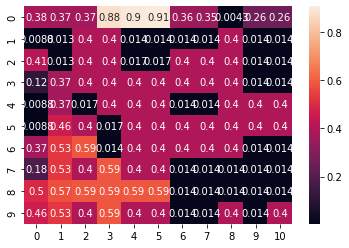

In [22]:
import seaborn as sns

sns.heatmap(k_means_matrix, annot=True)

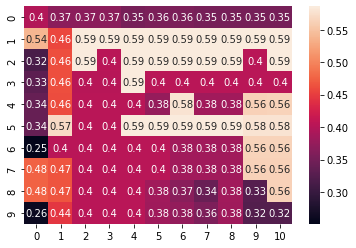

In [23]:
sns.heatmap(spectral_matrix, annot=True)

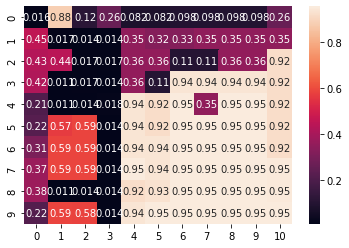

In [24]:
sns.heatmap(hierarchical_matrix, annot=True)

Как можно заметить, лучший результат дала иерархическая кластеризация при параметрах от (4,5) до (10,9)

In [25]:
clear_df = get_clear_df(9, 11)
train = preprocessing.normalize(clear_df.drop(['Текущий прогноз'], axis=1))
ans = clear_df['Текущий прогноз']

hierarchical_model = hierarchical(train,3)

hierarchical_accuracy = balanced_accuracy_score(hierarchical_model.labels_.astype(int), ans)
hierarchical_accuracy

0.950348432055749

In [26]:
import pickle
# сохранение модели

save_path = f'hierarchical_model_acc:{hierarchical_accuracy}.pkl'
with open(save_path, 'wb') as file:
  pickle.dump(hierarchical_model, file)

# Некая эвристика

В данных присутствует ошибка, а именно: в нулевом классе(живых людей без рецидива) есть записи, в которых значение столбца 'Рецидив' ненулевое. Поэтому для визуализации мы исправим эти ошибки.

In [27]:
new_df = df.copy()
new_df.loc[(new_df['Рецидив'] == 1) & (new_df['Текущий прогноз'] == 0) ,'Текущий прогноз'] = 2

Мы также отдельно анализировали влияние разных фичей на таргет, и нашли очень интересную зависимость

Можно заметить, что признак 'Рецидив' сильно влияет на выживаемость. В train выборке всего лишь один человек, который умер без рецидива.

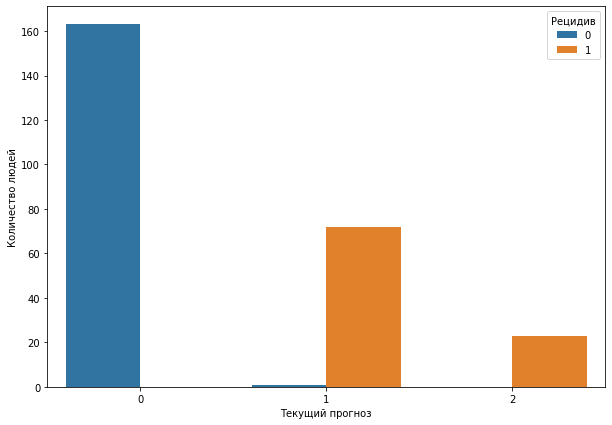

In [28]:


new_df['Количество людей'] = np.ones(len(new_df)) # небольшой костыль для графиков :)

plt.figure(figsize=(10,7))
ax = sns.barplot(x="Текущий прогноз", y="Количество людей", hue='Рецидив', data=new_df, estimator=sum)

Далее мы рассмотрели показатель 'диурез в сутки'. Оказалось, что из 73 умерших людей, у 72 был диурез в сутки, более, чем 2 тысячи. А из 186 живых людей всего у 28 был повышенный диурез.

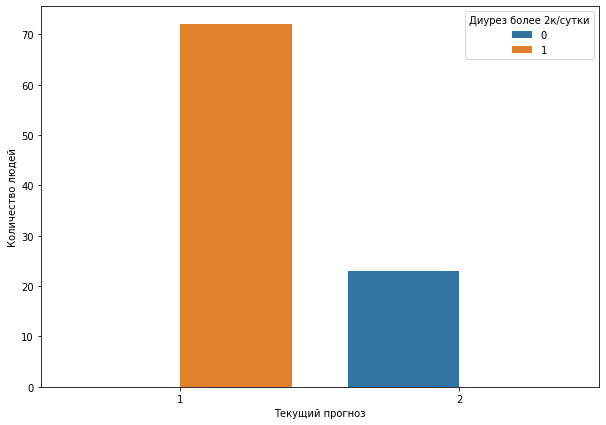

In [29]:
new_df['Диурез более 2к/сутки'] = (new_df['диурез, сутки'] >= 2000).astype(int)

plt.figure(figsize=(10,7))
ax = sns.barplot(x="Текущий прогноз", y="Количество людей",
                 hue='Диурез более 2к/сутки', data=new_df.loc[new_df['Рецидив'] == 1,:], estimator=sum)

In [30]:
new_df[new_df['Диурез более 2к/сутки'] == 1]['Текущий прогноз'].value_counts()

1    72
0    28
Name: Текущий прогноз, dtype: int64

In [31]:
new_df['Текущий прогноз'].value_counts()

0    163
1     73
2     23
Name: Текущий прогноз, dtype: int64

Далее мы, основываясь на зависимостях полученные выше, попробуем сделаем предсказание для train данных "руками".
Если конкретно, то у нас получились такие условия:
*   Если есть рецидив, и при этом диурёз в сутки >= 2000, человек умер (класс 1)
*   Если есть рецидив, и при этом значение диурёза не измерялось, то человек выжил с рецдивом (класс 2)
*   Остальные люди выжили без рецидива (класс 0)

In [32]:
def make_heuristic_predict(data):
  predictions = pd.DataFrame([0] * len(data), columns = ['Predictions'])
  predictions.loc[(data['Рецидив'] == 1) & (data['диурез, сутки'] >= 2000), 'Predictions'] = 1
  predictions.loc[(data['Рецидив'] == 1) & (df['диурез, сутки'] == 0), 'Predictions'] = 2
  return predictions['Predictions']

In [33]:
balanced_accuracy_score(make_heuristic_predict(df), df['Текущий прогноз'])

0.9813373253493015

На наше удивление, результаты получились лучше, чем у иерархической кластеризации, поэтому для итогового предикта будем использовать данный подход. (предикт делается в другом ноутбуке)